# Обучение с подкреплением
## Бодунов П.А. ФКТИ 0310
## Практическая №1 (DQN)

Установка gym:

In [ ]:
!pip install gym==0.26.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827728 sha256=3e7fbf82c541bc94735d7a18613f80eac90589ae53a23cc9040215a1af39249a
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


Необходимые библиотеки и выбор девайса:

In [ ]:
import math
import random
from collections import namedtuple, deque
from itertools import count
from typing import Type
from gymnasium.wrappers import RecordVideo
import gymnasium as gym
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from dataclasses import dataclass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cpu


Параметры нейронной сети:

In [ ]:
@dataclass
class Params:
    batch_size: int = 128
    gamma: float = 0.99
    eps_start: float = 0.9
    eps_end: float = 0.05
    eps_decay: float = 0.95
    lr: float = 0.001

### Буфер воспоминаний

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (
            torch.tensor(state, dtype=torch.float32),
            torch.tensor(action, dtype=torch.long),
            torch.tensor(reward, dtype=torch.float32),
            torch.tensor(next_state, dtype=torch.float32),
            torch.tensor(done, dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)

Методы:

- `__init__(self, capacity)` - задает буфер в виде очереди с максимальным размером capacity.
- `push(self, *args)` - добавление перехода в буффер.
- `sample(self, batch_size)` - сэмплирование (возврат из буфера `batch_size` рандомных переходов)
- `__len__(self)` - текущий размер буфера.

### Нейронная сеть для Q функции

#### QNetwork1

3 линейных слоя с функциями активации ReLU().

In [ ]:
class QNetwork1(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(QNetwork1, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_observations, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        return self.net(x)


#### QNetwork2

5 линейных слоев с функциями активации ReLU().

In [ ]:
class QNetwork2(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(QNetwork2, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_observations, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        return self.net(x)


#### QNetwork3

5 линейных слоев с функциями активации ReLU() и Sigmoid().

In [ ]:
class QNetwork3(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(QNetwork3, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_observations, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.Sigmoid(),
            nn.Linear(256, 128),
            nn.Sigmoid(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        return self.net(x)


### DQNAgent

In [ ]:
class DQNAgent:
    def __init__(self, model_type: Type[nn.Module], env: gym.Env, params: Params = None, buff_size = 1000):
        initial_state, _ = env.reset()
        n_observations = len(initial_state)
        self.n_actions = env.action_space.n
        self.params = params if params is not None else Params()

        self.q_net = model_type(n_observations, self.n_actions)
        self.target_net = model_type(n_observations, self.n_actions)
        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.params.lr)
        self.buffer = ReplayBuffer(buff_size)
        self.eps = self.params.eps_start
        self.q_net.to(device)
        self.target_net.to(device)

    def select_action(self, state):
        if random.random() < self.eps:
            return random.randint(0, self.n_actions - 1)

        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
        with torch.no_grad():
            return self.q_net(state_tensor).argmax().item()

    def train_step(self):
        if len(self.buffer) < self.params.batch_size:
            return 0
        state, action, reward, next_state, done = self.buffer.sample(self.params.batch_size)
        state, action, reward, next_state, done = state.to(device), \
            action.to(device), reward.to(device), next_state.to(device), done.to(device)

        q_vals = self.q_net(state).gather(1, action.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            target = reward + self.params.gamma * self.target_net(next_state).max(1)[0] * (1 - done)
        loss = nn.MSELoss()(q_vals, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def update_epsilon(self):
        self.eps = max(self.eps * self.params.eps_decay, self.params.eps_end)

    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())


- `select_action(self, state)` - выбор действия на основе состояния state.
- `train_step(self)` - шаг обучения.
- `update_epsilon(self)` - обновление $\varepsilon$ для $\varepsilon$-жадной политики.
- `update_target(self)` - обновление таргетной сетки новыми значениями q-сетки.

### Обучение нейронной сети

In [ ]:
def train(agent, env, n_epochs, steps):
    reward_history = []
    loss_history = []
    epoch_tqdm = tqdm(range(n_epochs))
    for epoch in epoch_tqdm:
        state, _ = env.reset()
        total_reward = 0
        total_loss = 0
        for _ in range(steps):
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            agent.buffer.push(state, action, reward, next_state, float(done))
            loss = agent.train_step()
            state = next_state

            total_reward += reward
            total_loss += loss

            if done:
                break

        reward_history.append(total_reward)
        loss_history.append(total_loss)

        agent.update_epsilon()
        agent.update_target()
        epoch_tqdm.desc = f"Reward: {total_reward}, Loss: {total_loss}"

    return reward_history, loss_history

### Функция построения графиков

In [ ]:
def plot_graphics(results, labels, main_title):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21, 6))
    fig.tight_layout(pad=5.0)
    fig.suptitle(main_title, fontsize=14)

    ax1.set_title("Reward")
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Reward')
    ax1.grid(True)

    ax2.set_title("Loss")
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True)

    for (rewards, losses), label in zip(results, labels):
        ax1.plot(rewards, label=label)
        ax2.plot(losses, label=label)

    ax1.legend()
    ax2.legend()

    plt.show()

### Эксперимент различных архитектур нейронной сети

In [ ]:
def experiment_models(env):
    labels = ["QNetwork1", "QNetwork2", "QNetwork3"]
    agents = [DQNAgent(QNetwork1, env), DQNAgent(QNetwork2, env), DQNAgent(QNetwork3, env)]
    results = []

    for agent, label in zip(agents, labels):
        print(f"{label} model train")
        results.append(train(agent, env, 300, 100))

    plot_graphics(results, labels, "Network")

### Эксперимент различных значений gamma и epsilon_decay


In [ ]:
def experiment_gamma_eps_decay(env):
    gammas = [0.99, 0.8, 0.6]
    labels = []
    results = []
    for gamma in gammas:
        label = f"gamma = {gamma}"
        labels.append(label)
        agent = DQNAgent(QNetwork1, env, Params(gamma=gamma))

        print(f"{label} model train")
        results.append(train(agent, env, 300, 100))

    plot_graphics(results, labels, "Gamma")


    eps_decays = [0.95, 0.8, 0.6]
    labels = []
    results = []
    for eps_decay in eps_decays:
        label = f"eps_decay = {eps_decay}"
        labels.append(label)
        agent = DQNAgent(QNetwork1, env, Params(eps_decay=eps_decay))

        print(f"{label} model train")
        results.append(train(agent, env, 300, 100))

    plot_graphics(results, labels, "Epsilon decay")


### Эксперимент, как изначальное значение epsilon влияет на скорость обучения

In [ ]:
def experiment_eps_start(env):
    eps_starts = [0.9, 0.8, 0.6, 0.3]
    labels = []
    results = []
    for eps_start in eps_starts:
        label = f"eps_start = {eps_start}"
        labels.append(label)
        agent = DQNAgent(QNetwork1, env, Params(eps_start=eps_start))

        print(f"{label} model train")
        results.append(train(agent, env, 300, 100))

    plot_graphics(results, labels, "Epsilon start")

Окружение CartPole

In [ ]:
env = gym.make("CartPole-v1")

## Эксперименты

QNetwork1 model train


Reward: 100.0, Loss: 0.8817834298824891: 100%|██████████| 300/300 [01:48<00:00,  2.77it/s]


QNetwork2 model train


Reward: 100.0, Loss: 11.749069273471832: 100%|██████████| 300/300 [03:36<00:00,  1.38it/s]


QNetwork3 model train


Reward: 100.0, Loss: 0.13194979980107746: 100%|██████████| 300/300 [03:10<00:00,  1.58it/s]


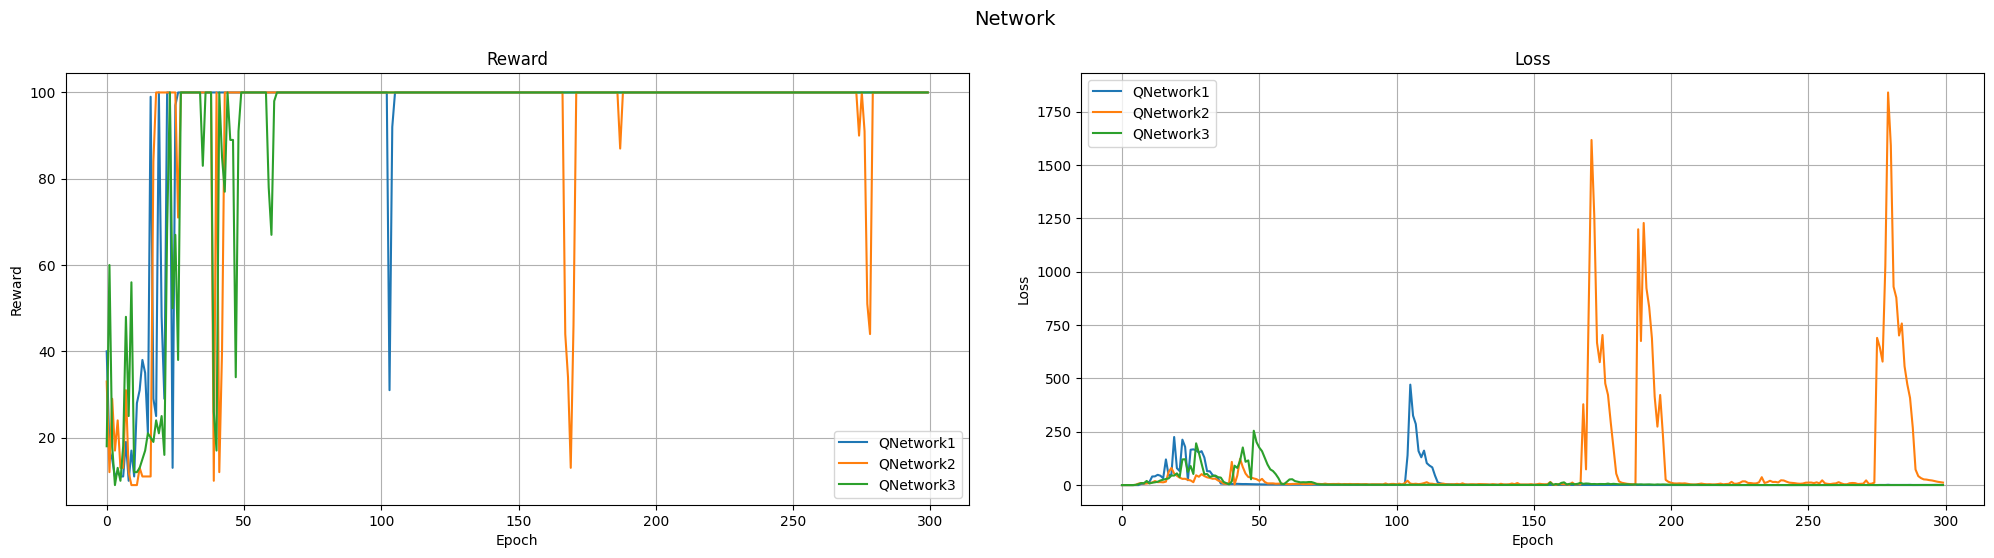

In [ ]:
experiment_models(env)

gamma = 0.99 model train


Reward: 100.0, Loss: 0.7383914275560528: 100%|██████████| 300/300 [01:48<00:00,  2.76it/s]


gamma = 0.8 model train


Reward: 100.0, Loss: 0.007075037588947453: 100%|██████████| 300/300 [01:48<00:00,  2.76it/s]


gamma = 0.6 model train


Reward: 100.0, Loss: 0.0025706154983708984: 100%|██████████| 300/300 [01:35<00:00,  3.13it/s]


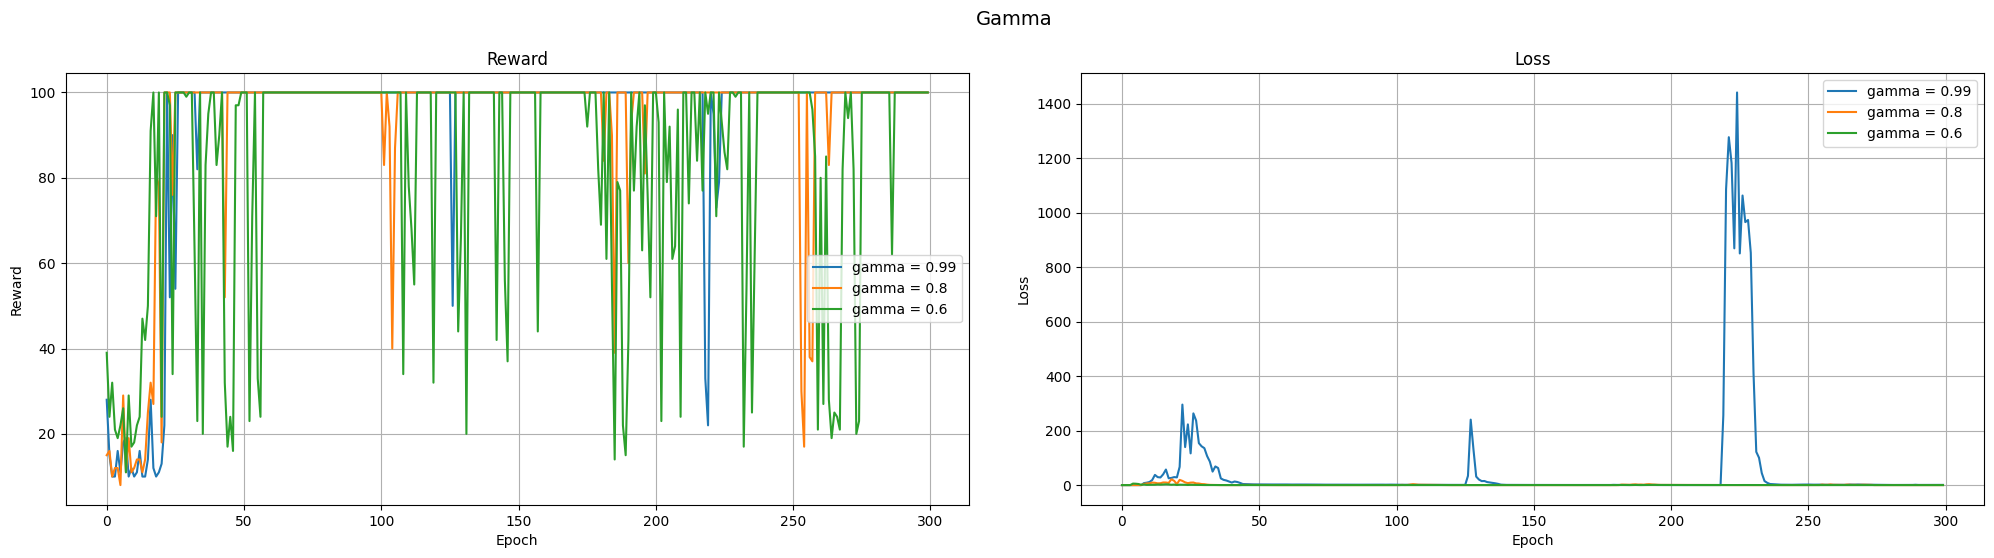

eps_decay = 0.95 model train


Reward: 100.0, Loss: 0.38518600340466946: 100%|██████████| 300/300 [01:48<00:00,  2.76it/s]


eps_decay = 0.8 model train


Reward: 100.0, Loss: 2.3228840585798025: 100%|██████████| 300/300 [01:48<00:00,  2.76it/s]


eps_decay = 0.6 model train


Reward: 100.0, Loss: 1.1556700831279159: 100%|██████████| 300/300 [01:42<00:00,  2.92it/s]


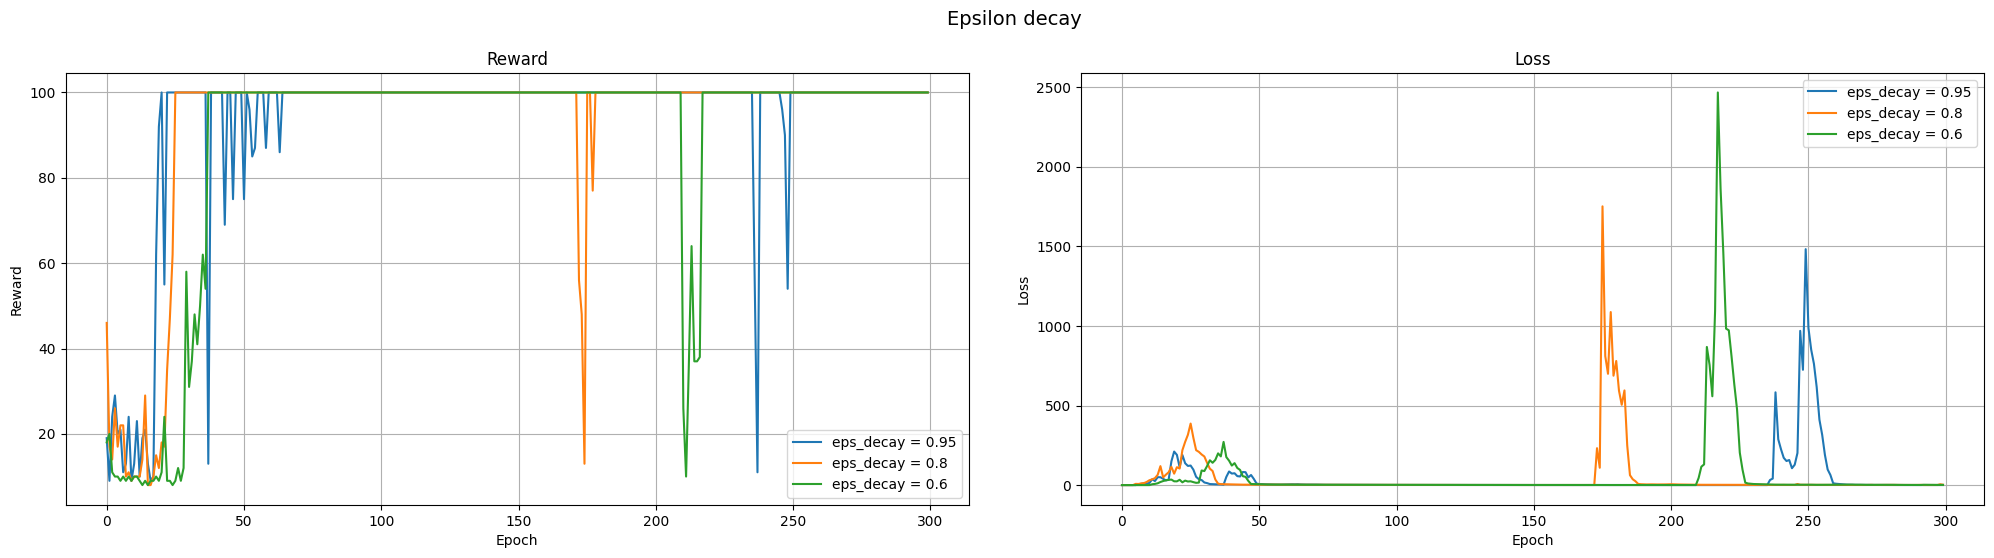

In [ ]:
experiment_gamma_eps_decay(env)

eps_start = 0.9 model train


Reward: 100.0, Loss: 1.160472644958645: 100%|██████████| 300/300 [01:41<00:00,  2.97it/s]


eps_start = 0.8 model train


Reward: 100.0, Loss: 0.7125704409554601: 100%|██████████| 300/300 [01:41<00:00,  2.96it/s]


eps_start = 0.6 model train


Reward: 100.0, Loss: 0.7743527160491794: 100%|██████████| 300/300 [01:39<00:00,  3.01it/s]


eps_start = 0.3 model train


Reward: 100.0, Loss: 3.793213624507189: 100%|██████████| 300/300 [01:35<00:00,  3.15it/s]


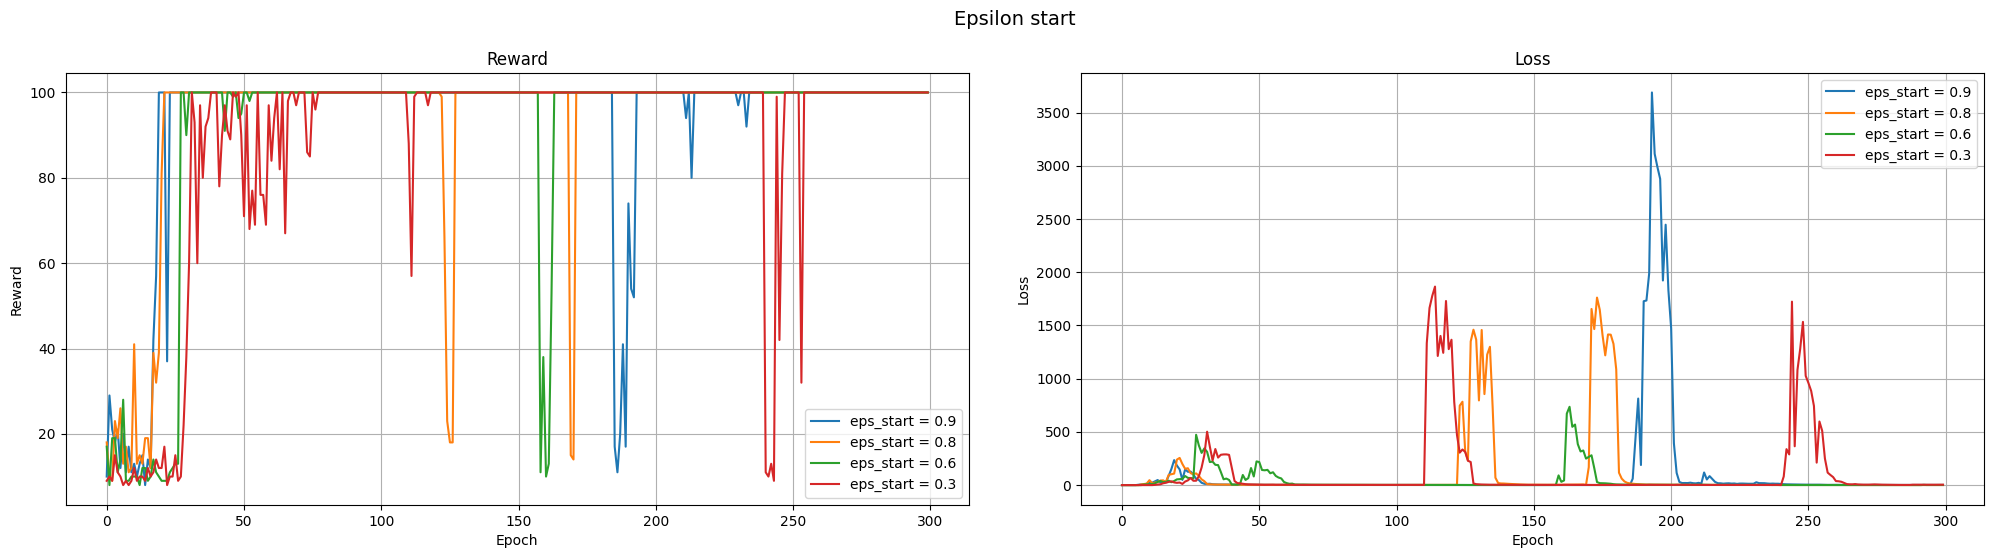

In [ ]:
experiment_eps_start(env)

### Визуализация результатов

Функция визуализации обученной модели (запись сохраняется в папку `videos`)

In [ ]:
def visualize_agent_performance(agent, env_name, model_name):
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env,
                     video_folder="./videos",
                     name_prefix=model_name,
                     video_length=7000,
                     episode_trigger=lambda x: True)

    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.select_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

        if total_reward > env.spec.reward_threshold:
           print(f"Total Reward: {total_reward}")
           break

    env.close()

Обучение агента

In [ ]:
agent = DQNAgent(QNetwork1, env)
res = train(agent, env, n_epochs=300, steps=200)

Reward: 200.0, Loss: 153.64620070159435: 100%|██████████| 300/300 [03:08<00:00,  1.59it/s]


Графики его обучения

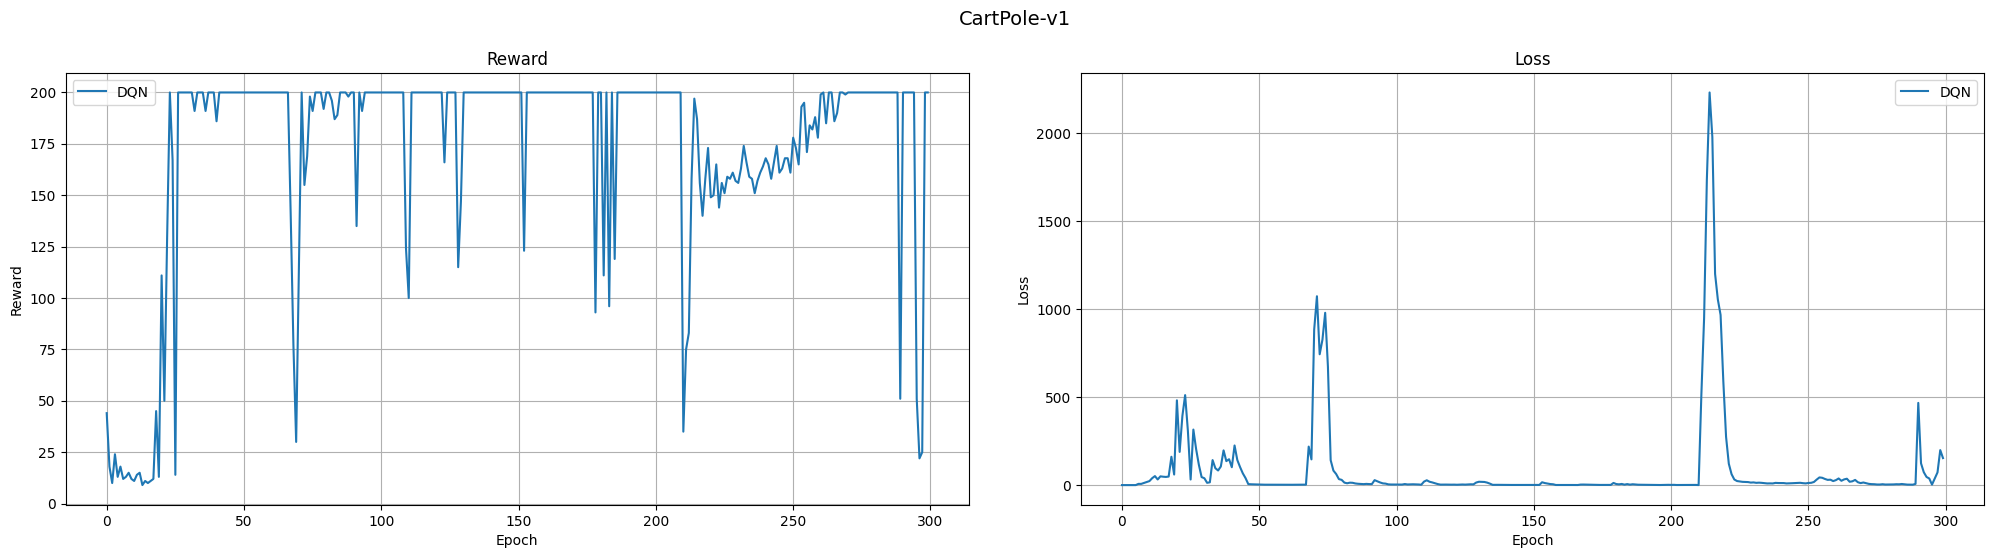

In [ ]:
plot_graphics([res], ['DQN'], "CartPole-v1")

In [ ]:
visualize_agent_performance(agent, 'CartPole-v1', 'dqn')

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Total Reward: 476.0
